In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd 
import numpy as np
from backtest.dataframe import TradeSession, PMPandas
from backtest.base_api import event_generator

# 信号处理

## 因子值

In [4]:
#用于回测的单因子
fct=pd.read_pickle("./factor.pickle") #单因子值,格式为有name的pd.series
fct.dropna().tail()

date      windcode 
20230427  128140.SZ    18.829575
          128141.SZ     4.113737
          128142.SZ     4.907253
          128143.SZ    10.290646
          128144.SZ     5.070907
Name: 因子值, dtype: float64

In [5]:
fct = fct.dropna().reset_index()
fct['date'] = pd.to_datetime(fct['date'])
fct.columns = ['date', 'code', 'value']

In [6]:
fct.tail()

,date,code,value
401435,2023-04-27,128140.SZ,18.829575
401436,2023-04-27,128141.SZ,4.113737
401437,2023-04-27,128142.SZ,4.907253
401438,2023-04-27,128143.SZ,10.290646
401439,2023-04-27,128144.SZ,5.070907


<Axes: >

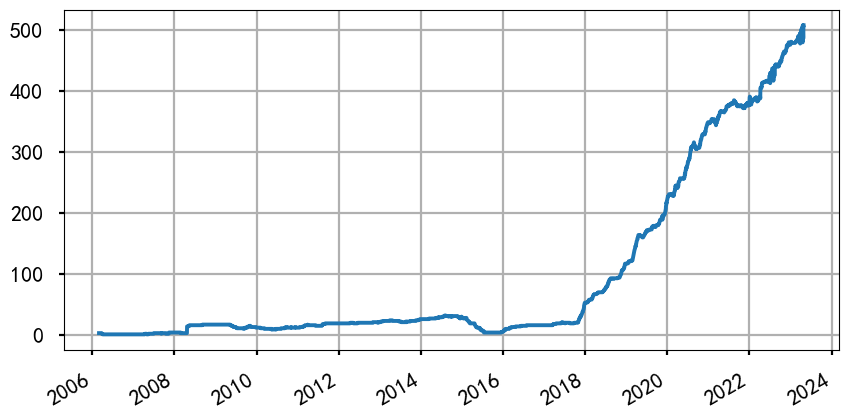

In [7]:
fct['date'].value_counts().sort_index().plot(figsize=(10, 5), grid=True)

<Axes: xlabel='date'>

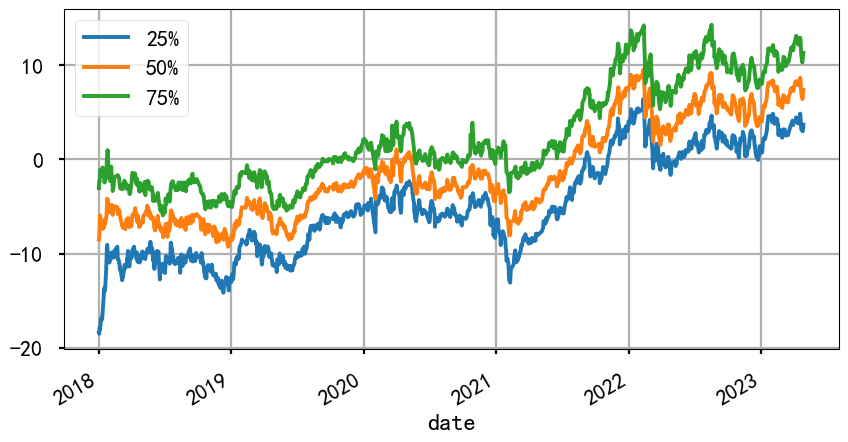

In [8]:
fct.groupby('date')['value'].describe().loc[
    '2018':,['25%', '50%', '75%']].plot(
    figsize=(10, 5), grid=True)

## 指数

In [9]:
index = pd.read_pickle("./zzeq.pickle")
index.tail()

date
20230421    2.133467
20230424    2.117063
20230425    2.105373
20230426    2.124780
20230427    2.133337
Name: 转债等权指数, dtype: float64

In [10]:
index.isnull().sum()

0

<Axes: xlabel='date'>

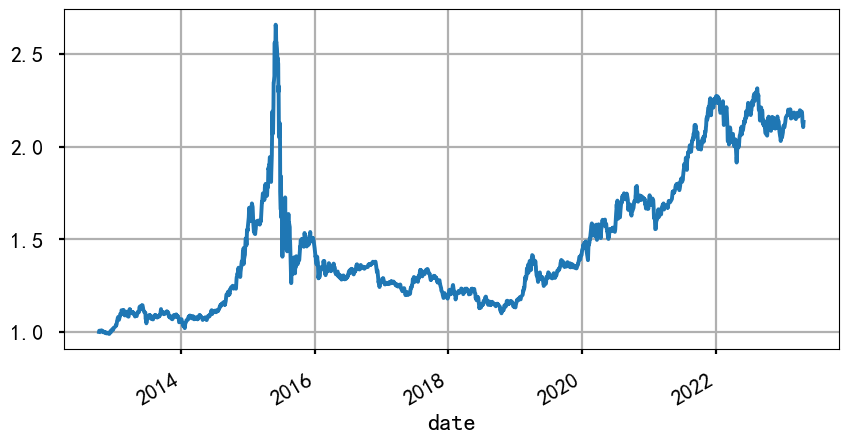

In [11]:
index.index = pd.to_datetime(index.index)
index.plot(figsize=(10, 5), grid=True)

## not_include

In [12]:
# not_include
not_include = pd.DataFrame(pd.read_pickle('not_include_list.pickle'),
    columns=['date', 'code'])
not_include['date'] = pd.to_datetime(not_include['date'])

not_include.head()

,date,code
0,2017-12-29,113502.SH
1,2018-01-02,113502.SH
2,2018-01-02,113503.SH
3,2018-01-03,113502.SH
4,2018-01-03,113503.SH


# 回测

## 初始化

In [13]:
ts = TradeSession(PMPandas, 
                  cash=1e8, 
                  start_datetime='2017-12-28',
                  end_datetime='2023-05-01', 
                  cb_daily_data_path=r'D:\mypkgs\backtest\data_mock\cbmkt.pickle')
date_weekend = pd.date_range(start='2017', end='2024', freq='w')
events_weekend = event_generator(date_weekend.to_pydatetime(), 'week_end', event_seq=5)
ts.add_events(events_weekend)

In [14]:
ts_events = pd.DataFrame(ts.events)
ts_events['event_type'].value_counts()

EventType.CLOSE      2754
EventType.OPEN       2754
EventType.RECORD     1295
EventType.WEEKEND     366
Name: event_type, dtype: int64

In [15]:
ts_events['event_type']= ts_events['event_type'].apply(lambda x:x.value)
ts_events.groupby('event_type')['datetime'].agg(['min', 'max'])

,min,max
event_type,,
close,2012-01-04 15:00:00,2023-05-08 15:00:00
open,2012-01-04 09:30:00,2023-05-08 09:30:00
record,2017-12-28 20:00:00,2023-04-28 20:00:00
week_end,2017-01-01 00:00:00,2023-12-31 00:00:00


In [16]:
# 每次回测前会根据时间把多余的事件过滤掉
backtest_events = ts.get_event_dict() 
cal_temp = []
for t in sorted(backtest_events.keys()):
    for event in backtest_events[t]:
        cal_temp += [[t, event.event_type.value]]
pd.DataFrame(cal_temp,
             columns=['datetime', 'event_type'
                      ]).groupby('event_type')['datetime'].agg(['min', 'max'])

,min,max
event_type,,
close,2017-12-28 15:00:00,2023-04-28 15:00:00
open,2017-12-28 09:30:00,2023-04-28 09:30:00
record,2017-12-28 20:00:00,2023-04-28 20:00:00
week_end,2017-12-31 00:00:00,2023-04-30 00:00:00


## 简单的定期选股回测

1. 回测时间段为20171229至今，策略净值的起始日为20180102，20171229的数据仅用于观察因子值排名、并确定20180102的持仓名单，严格意义上的回测是20180102至今；


2. 调仓周期为周度，假设W1、W2为连续两个自然周，W1的最后一个交易日观察因子排名，【按fct中的因子值排名后20%得到W2的转债持仓list(等权持有)】，并于W2的第一个交易日开盘进行调仓与再平衡（买入在list中但未持有的转债、卖出不在list中但正持有的转债，对在list中且正持有的转债进行再平衡）；


3. 成交顺序为先卖出再买入（确保有足够多的现金）；


4. W1第一个交易日收盘时，观察实际成交的情况，可考虑将交易划分为三类：建仓、清仓、再平衡（如下图）：

    1） 对于清仓的转债，若存在未卖完的部分，第二个、第三个、第四个交易日继续卖，直到卖完为止； 若到W1的最后一个交易日收盘仍未卖完，则根据W1最后一个交易日因子值给出得list建议进行操作，若不在list中，则在W2中继续卖；若在list中，则撤出剩余的卖单，根据list建议在W2中进行买入
    
    2） 对于建仓及再平衡的转债，若剩余未成交金额<=15w，则撤单不再买入，否则在第二个、第三个、第四个交易日继续交易，直到交易完成或者本周最后一个交易日，按照更新后的持仓list进行操作
    
    
5. 回测2中情形，1）没有成交额限制（个券成交额不高于当日实际成交额的100%）；2）有成交额限制（不高于当日实际成交额的10%）


6. 交易成本的假设：按vwap成交的情况下，无需考虑冲击成本？ or 冲击成本单边1‰


7. 返回内容：策略净值、持仓/调仓记录、策略换手情况

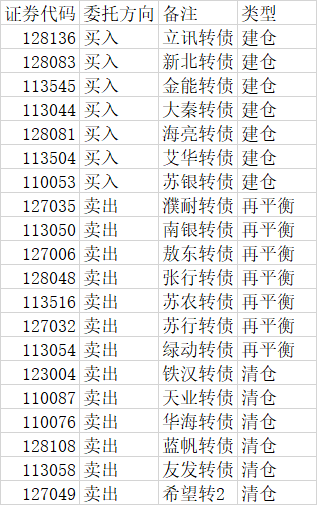

In [17]:
class PMSimple(PMPandas):
    def init(self):
        mkt = self.get_mkt_obj()
        mkt.buy_fee_ratio = 5e-4 + 5e-4  # 佣金与冲击成本
        mkt.sell_fee_ratio = 5e-4 + 5e-4 + 1e-3  # 佣金与冲击成本与印花税
        mkt.vwap_volume_limit_ratio = 0.05  # 成交量占当日的成交量上限
        self.week_count = 0  # 用于打印回测进度
        self.add_factor()
        self.send_record = pd.DataFrame()

    def after_close(self):
        # 如果成交量小于1手则取消订单
        active_orders = self.active_orders
        l_long = active_orders['targetVol'] > active_orders['filledVol']
        l_amount = active_orders['targetVol'] - active_orders['filledVol'] < 10 # 一手的量 
        self.cancel_orders(active_orders.loc[l_amount & l_long])

    def after_week_end(self):
        # 打印日志
        self.week_count += 1
        if self.week_count % 20 == 0:
            print(self.observer.time, self.balance['netAsset'])
            
        # 每周末， 取消所有的活跃订单(0号和1号订单代表不会被取消的订单)
        self.cancel_orders(self.active_orders)
        
        # 计算买单
        # 计算标的之间的相对持仓比例， 如果是等权持仓随便传入一个正数即可
        self.select_secu_tobuy()
        self.order_data['ratio_relative'] = 7.5
        
        self.send_record = pd.concat((self.send_record, self.order_data))

        # 发送订单
        # target_ratio_VWAP 会根据输入的ratio_relative（标的相对的权重）与ratio_to_netasset（总的买入资金占净资产的比例）
        # 订单策略会根据输入的比例，自动计算目标仓位，并结合当前的持仓进行开、平操作，避免额外的费用
        # 注意，因为发送订单的时候并不知道未来价格波动以及订单是否会被成交，因此给出的结果是近似结果
        self.send_orders(
            self.order_data,  # 订单的信息， 需要的字段由 order_type决定， 大部分情况下包含 code，ratio_relative两列 或 code， targetVol两列组合
            order_type='target_ratio_vwap',  # 订单算法详见 cb_daily.CBTargetRatioVWAP
            ratio_to_netasset=1,  # 买入的金额占组合净资产的比例， 如果是1则表示满仓买入
            order_seq_short=5,  # 卖单的交易顺序
            order_seq_long=10)  # 买单的交易顺序
        
    def add_factor(self):
        "初始化的时候把不复合条件的标的删除"
        res = pd.merge(fct, not_include, on=['date', 'code'], how='outer', indicator=True)
        l = res['_merge'] == 'left_only'
        self.fct = res.loc[l]
        del self.fct['_merge']
    
    def select_secu_tobuy(self):
        # 选择要持仓的股票
        mkt = self.get_mkt_obj()
        fct_temp = self.get_last_fct()
        l_top20 = fct_temp['value'] < fct_temp['value'].quantile(0.2)  # 小于20%
        l_valide = fct_temp['code'].isin(
            mkt.current_frame.index)  # 有些股票有因子值但是没有行情信息
        self.order_data = fct_temp.loc[l_top20 & l_valide].copy()

    def get_last_fct(self):
        # 获取最新交易日对应的因子值
        # 注意， 这种方法获取的因子值只能收盘后使用（xx日开盘的时候因子值很可能尚未计算出来）
        mkt = self.get_mkt_obj()
        last_trade_date = mkt.trade_date
        return (self.fct.query("date ==@last_trade_date"))

In [18]:
# 回测，加载策略，运行回测
ts.PortfolioManager = PMSimple
obs = ts.run()

2018-05-13 00:00:00 108155954.45583664
2018-09-30 00:00:00 101311047.40184471
2019-02-17 00:00:00 111007466.70073266
2019-07-07 00:00:00 131955751.65673843
2019-11-24 00:00:00 138637662.86523792
2020-04-12 00:00:00 165173629.03846544
2020-08-30 00:00:00 192447219.51817495
2021-01-17 00:00:00 181751920.05332583
2021-06-06 00:00:00 209774161.11219478
2021-10-24 00:00:00 238019646.05907267
2022-03-13 00:00:00 255684987.3470634
2022-07-31 00:00:00 272550584.948357
2022-12-18 00:00:00 260730631.52772227


### 结果

#### 组合现状

In [19]:
obs.position

,orderID,tradeID,secuType,code,transTime,transPrice,settlePrice,volume,frozenVol
0,15390,21880,cb_daily,110072.SH,2020-12-21 15:00:00,87.548372,92.8315,36195.876157,36195.876157
1,20559,30006,cb_daily,128100.SZ,2021-08-23 15:00:00,101.251509,70.2027,23984.357429,23984.357429
2,20559,30074,cb_daily,128100.SZ,2021-08-24 15:00:00,101.132697,70.2027,7916.796297,7916.796297
3,20559,30131,cb_daily,128100.SZ,2021-08-25 15:00:00,100.546513,70.2027,4924.097417,4924.097417
4,20559,30182,cb_daily,128100.SZ,2021-08-26 15:00:00,100.878142,70.2027,862.405128,862.405128
...,...,...,...,...,...,...,...,...,...
737,35274,52137,cb_daily,123063.SZ,2023-04-27 15:00:00,125.342670,126.6849,21.881431,21.881431
738,35275,52138,cb_daily,123104.SZ,2023-04-27 15:00:00,120.830549,121.2795,105.635487,105.635487
739,35280,52139,cb_daily,128075.SZ,2023-04-27 15:00:00,121.511432,122.0911,22.916307,22.916307
740,35281,52140,cb_daily,128141.SZ,2023-04-27 15:00:00,124.695148,125.6156,132.226878,132.226878


##### 持仓中由很多持仓很久的仓位

1. 仓位按标的聚合后数量就少了
2. 持仓中最早出现的股票一直处于买入列表中

<Axes: >

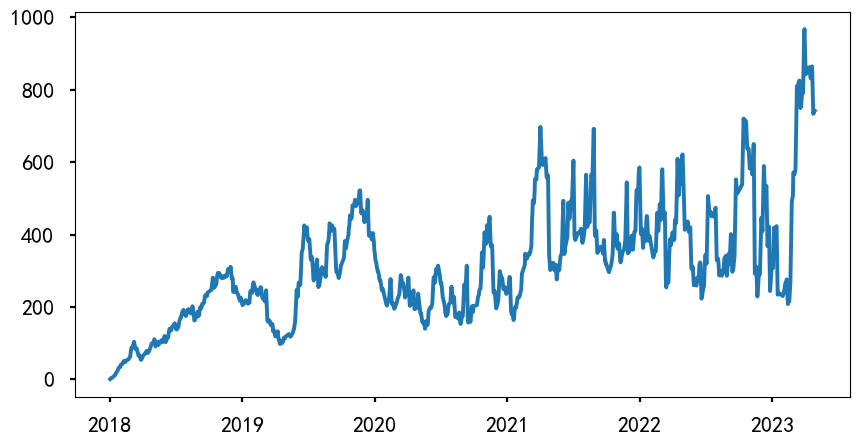

In [20]:
obs.position_records['date'].value_counts().sort_index().plot(figsize=(10,5))

<Axes: >

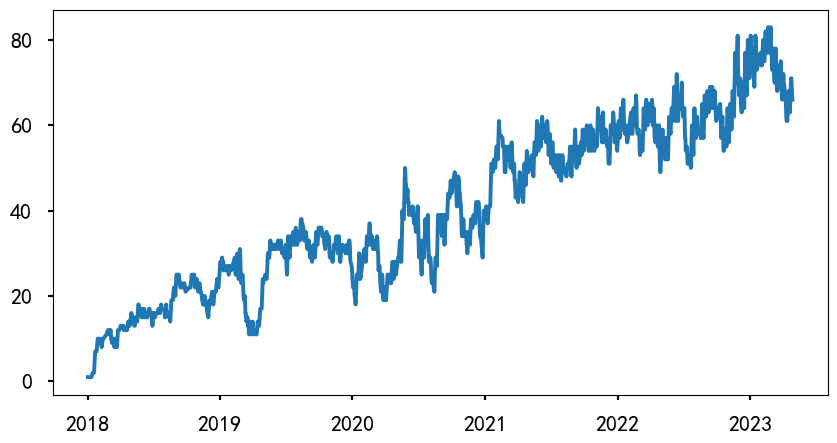

In [22]:
obs.position_records.groupby(['code', 'date'], as_index=False)[
    'volume'].sum()['date'].value_counts().sort_index().plot(figsize=(10,5))

In [23]:
obs.position.sort_values('transTime').head()

,orderID,tradeID,secuType,code,transTime,transPrice,settlePrice,volume,frozenVol
0,15390,21880,cb_daily,110072.SH,2020-12-21 15:00:00,87.548372,92.8315,36195.876157,36195.876157
1,20559,30006,cb_daily,128100.SZ,2021-08-23 15:00:00,101.251509,70.2027,23984.357429,23984.357429
2,20559,30074,cb_daily,128100.SZ,2021-08-24 15:00:00,101.132697,70.2027,7916.796297,7916.796297
3,20559,30131,cb_daily,128100.SZ,2021-08-25 15:00:00,100.546513,70.2027,4924.097417,4924.097417
4,20559,30182,cb_daily,128100.SZ,2021-08-26 15:00:00,100.878142,70.2027,862.405128,862.405128


In [24]:
res = pd.pivot(ts.pm.send_record.drop_duplicates(subset=['code', 'date']), 
               columns='code', index='date', values='value')
res.tail()

code,110034.SH,110038.SH,110039.SH,110041.SH,110043.SH,110044.SH,110045.SH,110046.SH,110047.SH,110049.SH,...,128130.SZ,128132.SZ,128133.SZ,128138.SZ,128139.SZ,128140.SZ,128141.SZ,128142.SZ,128144.SZ,128145.SZ
date,,,,,,,,,,,,,,,,,,,,,
2023-03-24,NaN,NaN,NaN,NaN,1.493133,NaN,NaN,NaN,0.990289,NaN,...,NaN,0.864091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-31,NaN,NaN,NaN,NaN,1.602763,NaN,NaN,NaN,0.953776,NaN,...,NaN,1.091033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-07,NaN,NaN,NaN,NaN,2.303374,NaN,NaN,NaN,1.724138,NaN,...,NaN,2.966588,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-14,NaN,NaN,NaN,NaN,2.415900,NaN,NaN,NaN,1.699136,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.159673,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.610183,NaN,NaN,NaN


In [25]:
# 判断是否自从2021年后一直处于buy列表中
(res.loc['2020-12-21':, '110072.SH'].isnull().sum() == 0,
 res.loc['2021-08-23':, '128100.SZ'].isnull().sum() == 0,
 res.loc['2021-11-01':, '127018.SZ'].isnull().sum() == 0,
 res.loc['2021-11-15':, '113021.SH'].isnull().sum() == 0,)

(True, True, True, True)

##### 净资产

In [26]:
obs.balance

{'netAsset': 268196914.38053235, 'cash': 2111951.3114072923, 'frozenCash': 0}

In [27]:
obs.active_orders

,orderID,secuType,code,orderTime,orderType,direction,targetPrice,targetVol,filledVol,offsetID,status,orderSeq
0,35501,cb_daily,128141.SZ,2023-04-30,vwap,net,125.6156,-132.226878,0.0,52140,unsubmit,5
1,35502,cb_daily,128141.SZ,2023-04-30,vwap,net,125.6156,-12216.704024,0.0,52128,unsubmit,5
2,35503,cb_daily,128141.SZ,2023-04-30,vwap,net,125.6156,-10678.812801,0.0,52108,unsubmit,5
3,35504,cb_daily,128141.SZ,2023-04-30,vwap,net,125.6156,-10478.650000,0.0,52085,unsubmit,5
4,35505,cb_daily,128129.SZ,2023-04-30,vwap,net,101.0576,-1088.956055,0.0,50997,unsubmit,5
...,...,...,...,...,...,...,...,...,...,...,...,...
737,36238,cb_daily,110047.SH,2023-04-30,vwap,net,116.5598,-78.110866,0.0,49344,unsubmit,5
738,36239,cb_daily,110047.SH,2023-04-30,vwap,net,116.5598,-530.905893,0.0,49258,unsubmit,5
739,36240,cb_daily,110047.SH,2023-04-30,vwap,net,116.5598,-2583.067796,0.0,45027,unsubmit,5
740,36241,cb_daily,110047.SH,2023-04-30,vwap,net,116.5598,-11012.653613,0.0,44985,unsubmit,5


In [28]:
obs.active_order_params

{}

#### 交易记录

In [29]:
obs.trade_records.tail()

,tradeID,orderID,secuType,code,transTime,direction,transPrice,transVol,offsetID,transCost
52140,52140,35281,cb_daily,128141.SZ,2023-04-27 15:00:00,long,124.695148,132.226878,-1,16.488050
52141,52141,35365,cb_daily,113516.SH,2023-04-28 15:00:00,net,113.042254,-4607.251406,49006,1041.628171
52142,52142,35366,cb_daily,113516.SH,2023-04-28 15:00:00,net,113.042254,-3287.500000,48962,743.252823
52143,52143,35331,cb_daily,127044.SZ,2023-04-28 15:00:00,net,113.398434,-3975.300000,49990,901.585590
52144,52144,35283,cb_daily,123049.SZ,2023-04-28 15:00:00,long,106.629644,4469.900000,-1,476.623845


#### balance记录

In [30]:
obs.balance_records.tail()

,recordTime,netAsset,cash,frozenCash,date
1290,2023-04-24 20:00:00,2.648238e+08,2.039490e+06,1.759990e+07,2023-04-24
1291,2023-04-25 20:00:00,2.645803e+08,0.000000e+00,8.655946e+06,2023-04-25
1292,2023-04-26 20:00:00,2.654429e+08,9.313226e-10,2.877152e+06,2023-04-26
1293,2023-04-27 20:00:00,2.668514e+08,1.248505e+06,2.366582e+06,2023-04-27
1294,2023-04-28 20:00:00,2.681969e+08,2.111951e+06,1.901240e+06,2023-04-28


#### 持仓记录

In [31]:
obs.position_records

,recordTime,orderID,tradeID,secuType,code,transTime,transPrice,settlePrice,volume,frozenVol,date,mktv
0,2018-01-02 20:00:00,0,0,cb_daily,110039.SH,2018-01-02 15:00:00,106.939570,107.1314,9204.000000,-0.0,2018-01-02,9.860374e+05
1,2018-01-03 20:00:00,0,0,cb_daily,110039.SH,2018-01-02 15:00:00,106.939570,107.9605,9204.000000,-0.0,2018-01-03,9.936684e+05
2,2018-01-03 20:00:00,0,1,cb_daily,110039.SH,2018-01-03 15:00:00,107.955941,107.9605,11331.000000,-0.0,2018-01-03,1.223300e+06
3,2018-01-04 20:00:00,0,0,cb_daily,110039.SH,2018-01-02 15:00:00,106.939570,110.3097,9204.000000,-0.0,2018-01-04,1.015290e+06
4,2018-01-04 20:00:00,0,1,cb_daily,110039.SH,2018-01-03 15:00:00,107.955941,110.3097,11331.000000,-0.0,2018-01-04,1.249919e+06
...,...,...,...,...,...,...,...,...,...,...,...,...
409193,2023-04-28 20:00:00,35274,52137,cb_daily,123063.SZ,2023-04-27 15:00:00,125.342670,126.6849,21.881431,-0.0,2023-04-28,2.772047e+03
409194,2023-04-28 20:00:00,35275,52138,cb_daily,123104.SZ,2023-04-27 15:00:00,120.830549,121.2795,105.635487,-0.0,2023-04-28,1.281142e+04
409195,2023-04-28 20:00:00,35280,52139,cb_daily,128075.SZ,2023-04-27 15:00:00,121.511432,122.0911,22.916307,-0.0,2023-04-28,2.797877e+03
409196,2023-04-28 20:00:00,35281,52140,cb_daily,128141.SZ,2023-04-27 15:00:00,124.695148,125.6156,132.226878,-0.0,2023-04-28,1.660976e+04


### 检查

#### 持仓资产+现金等于基金净值

In [32]:
obs.check_position_net()

,netAsset,cash,position_asset,netAsset_cal
recordTime,,,,
2017-12-28 20:00:00,1.000000e+08,1.000000e+08,NaN,1.000000e+08
2017-12-29 20:00:00,1.000000e+08,1.000000e+08,NaN,1.000000e+08
2018-01-02 20:00:00,1.000008e+08,9.901474e+07,9.860374e+05,1.000008e+08
2018-01-03 20:00:00,1.000072e+08,9.779027e+07,2.216969e+06,1.000072e+08
2018-01-04 20:00:00,1.000622e+08,9.612653e+07,3.935685e+06,1.000622e+08
...,...,...,...,...
2023-04-24 20:00:00,2.648238e+08,2.039490e+06,2.627843e+08,2.648238e+08
2023-04-25 20:00:00,2.645803e+08,0.000000e+00,2.645803e+08,2.645803e+08
2023-04-26 20:00:00,2.654429e+08,9.313226e-10,2.654429e+08,2.654429e+08


#### 期初期末持仓价值变动+期间的交易的费用=期初期末净资产的变动

In [33]:
obs.check_trade_net()

{'nav_end': 268196914.38053235,
 'nav_start': 100000781.3338,
 'trade_amount': 67533464.13729511,
 'trade_cost': 29369328.4794974,
 'pv_end': 266084963.06912628,
 'pv_start': 986037.4055999999,
 'nav_end_cal': 268196914.38053375}

In [34]:
res = obs.check_trade_net()
print('手续费：', -1*res['trade_cost'] / 1e8)

手续费： -0.293693284794974


In [35]:
print('交易贡献：', (res['pv_end'] - res['pv_start'] - res['trade_amount'])/ 1e8)

交易贡献： 1.9756546152623118


#### 期末持仓等于期初持仓+期间的交易

In [36]:
obs.check_trade_position(start_datetime='2018-01-01', end_datetime='2019-01-01')

volume_start  volume_trade    volume_end    volume_net
secuType code                                                             
cb_daily 110039.SH        9204.0 -9.204000e+03           NaN -1.091394e-11
         110041.SH           NaN  0.000000e+00           NaN  0.000000e+00
         110043.SH           NaN  7.275958e-12           NaN  7.275958e-12
         110044.SH           NaN  6.836577e+04  68365.766078  0.000000e+00
         110045.SH           NaN  6.915704e+04  69157.044962 -1.455192e-11
         110046.SH           NaN  3.547229e+04  35472.285253  0.000000e+00
         110047.SH           NaN  6.698940e+04  66989.403749  0.000000e+00
         113015.SH           NaN  1.818989e-12           NaN  1.818989e-12
         113017.SH           NaN -3.865352e-12           NaN -3.865352e-12
         113505.SH           NaN  2.273737e-13           NaN  2.273737e-13
         113506.SH           NaN  6.387631e+04  63876.311851  0.000000e+00
         113507.SH           NaN -1.818989e-12           NaN -1.818989e-12
         113508.SH           NaN  0.000000e+00           NaN  0.000000e+00
         113509.SH           NaN  5.304487e+04  53044.873358  0.000000e+00
         113511.SH           NaN  0.000000e+00           NaN  0.000000e+00
         113513.SH           NaN  5.791793e+04  57917.930840  0.000000e+00
         113515.SH           NaN  5.012895e+04  50128.952041  0.000000e+00
         113516.SH           NaN -3.637979e-12           NaN -3.637979e-12
         113517.SH           NaN  3.637979e-12           NaN  3.637979e-12
         113518.SH           NaN  4.928246e+04  49282.457469  0.000000e+00
         113519.SH           NaN  5.847081e+04  58470.813172  0.000000e+00
         113521.SH           NaN  1.969571e+04  19695.707570  0.000000e+00
         113522.SH           NaN  2.871898e+04  28718.980144  0.000000e+00
         123001.SZ           NaN  7.089042e+04  70890.415065 -1.455192e-11
         123003.SZ           NaN  2.728484e-12           NaN  2.728484e-12
         123005.SZ           NaN  1.455192e-11           NaN  1.455192e-11
         123006.SZ           NaN  7.275958e-12           NaN  7.275958e-12
         123007.SZ           NaN -4.547474e-13           NaN -4.547474e-13
         123008.SZ           NaN  0.000000e+00           NaN  0.000000e+00
         123009.SZ           NaN  0.000000e+00           NaN  0.000000e+00
         123010.SZ           NaN -6.821210e-13           NaN -6.821210e-13
         123011.SZ           NaN  7.247149e+03   7247.149408 -9.094947e-13
         123012.SZ           NaN  3.637979e-12           NaN  3.637979e-12
         123014.SZ           NaN  6.248148e+04  62481.479587  0.000000e+00
         123015.SZ           NaN  2.401762e+04  24017.615909  0.000000e+00
         127007.SZ           NaN -3.637979e-12           NaN -3.637979e-12
         128012.SZ           NaN  3.411436e+04  34114.360728 -7.275958e-12
         128018.SZ           NaN -3.637979e-12           NaN -3.637979e-12
         128019.SZ           NaN  0.000000e+00           NaN  0.000000e+00
         128021.SZ           NaN  4.274262e+04  42742.615413  0.000000e+00
         128023.SZ           NaN  9.094947e-13           NaN  9.094947e-13
         128026.SZ           NaN  7.275958e-12           NaN  7.275958e-12
         128027.SZ           NaN  0.000000e+00           NaN  0.000000e+00
         128028.SZ           NaN  1.818989e-12           NaN  1.818989e-12
         128029.SZ           NaN  0.000000e+00           NaN  0.000000e+00
         128032.SZ           NaN  2.728484e-12           NaN  2.728484e-12
         128033.SZ           NaN  0.000000e+00           NaN  0.000000e+00
         128034.SZ           NaN  0.000000e+00           NaN  0.000000e+00
         128036.SZ           NaN -2.273737e-13           NaN -2.273737e-13
         128037.SZ           NaN  0.000000e+00           NaN  0.000000e+00
         128038.SZ           NaN  7.596529e+04  75965.285610  0.000000e+00
         128039.SZ           NaN  3.183231e-1

### 分析

#### 基金指标

In [37]:
obs.pnl_analyse(freq='day', benchmark=index,  chicol=True)

,总收益率,年化收益率,年化风险,最大回撤,夏普比率,信息比率
netAsset,1.668514,0.203485,0.135805,0.150110,1.498364,1.2332
benchmark,0.807694,0.118206,0.126991,0.157759,0.930818,NaN


#### 净值

In [38]:
obs.get_pnl_net(benchmark=index, freq='day')

,netAsset,benchmark
2017-12-28,1.000000e+08,1.180143
2017-12-29,1.000000e+08,1.186481
2018-01-02,1.000008e+08,1.196686
2018-01-03,1.000072e+08,1.210064
2018-01-04,1.000622e+08,1.215429
...,...,...
2023-04-21,2.659361e+08,2.133467
2023-04-24,2.648238e+08,2.117063
2023-04-25,2.645803e+08,2.105373
2023-04-26,2.654429e+08,2.124780


#### 净值图

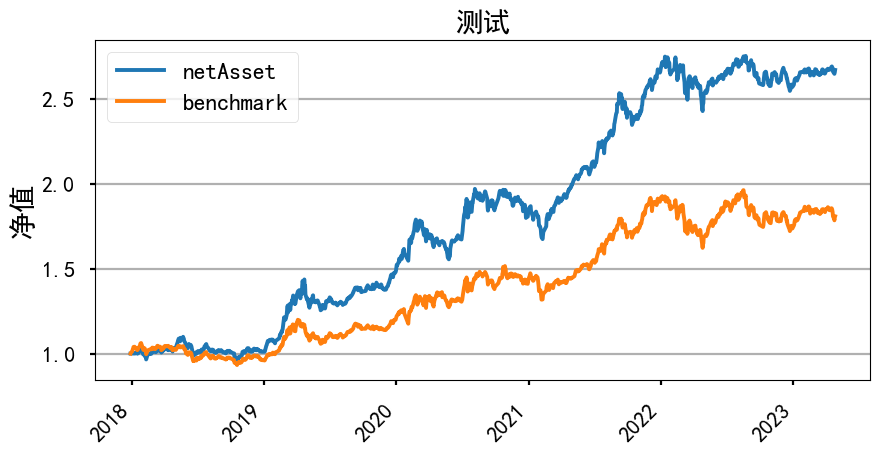

In [39]:
obs.pnl_plot(title='测试',benchmark=index, freq='day')

#### 换手率

##### 换手率 = （期间成交额+交易成本） / （期初组合净资产 + 期末组合净资产）

In [40]:
obs.cal_hsl(start_datetime='2018-01-10', end_datetime='2018-01-18', include_trade_cost=False)

{'start_record_time': Timestamp('2018-01-10 20:00:00'),
 'end_record_time': Timestamp('2018-01-17 20:00:00'),
 'nav_end': 100066467.26399998,
 'nav_start': 100223656.41327,
 'trade_amount': 11031906.120000001,
 'trade_cost': 11031.906120000001,
 'hsl': 0.05507963107445003}

默认从开始到结束

In [41]:
obs.cal_hsl( include_trade_cost=False)

{'start_record_time': Timestamp('2017-12-28 20:00:00'),
 'end_record_time': Timestamp('2023-04-28 20:00:00'),
 'nav_end': 268196914.38053235,
 'nav_start': 100000000.0,
 'trade_amount': 19603047746.177284,
 'trade_cost': 29370312.7512974,
 'hsl': 53.2406627555751}

##### 周换手率


1. start_datetime 统计开始日期 周末
1. end_datetime 统计结束日期 下周末 + 2天
1. 为什么要+2天？ 
    1.  observer会根据输入的start_datetime与end_datetime自动匹配时间区间内最大和最小的recordTime
    2. recordTime默认是每个交易日结束后记录一次， 为了统计一周的换手率需要从本周一的收盘跨到下一周的收盘
    3. start_datetime = 周末，则会自动匹配周一的recordTime
    4. end_datetime = 周末加2天， 会自动匹配下周一的recordTime

In [42]:
t_start = date_weekend
t_end = date_weekend + pd.offsets.Day(7+2)
[*zip(t_start, t_end)][:5]

[(Timestamp('2017-01-01 00:00:00', freq='W-SUN'),
  Timestamp('2017-01-10 00:00:00')),
 (Timestamp('2017-01-08 00:00:00', freq='W-SUN'),
  Timestamp('2017-01-17 00:00:00')),
 (Timestamp('2017-01-15 00:00:00', freq='W-SUN'),
  Timestamp('2017-01-24 00:00:00')),
 (Timestamp('2017-01-22 00:00:00', freq='W-SUN'),
  Timestamp('2017-01-31 00:00:00')),
 (Timestamp('2017-01-29 00:00:00', freq='W-SUN'),
  Timestamp('2017-02-07 00:00:00'))]

In [43]:
hsl = obs.cal_hsl_batch(t_start, t_end, include_trade_cost=False)
hsl.tail()

,start_record_time,end_record_time,nav_end,nav_start,trade_amount,trade_cost,hsl
274,2023-03-27 20:00:00,2023-04-03 20:00:00,2.667666e+08,2.662131e+08,9.195911e+07,138007.674340,0.172797
275,2023-04-03 20:00:00,2023-04-10 20:00:00,2.671072e+08,2.667666e+08,7.493467e+07,117222.794443,0.140580
276,2023-04-10 20:00:00,2023-04-17 20:00:00,2.687342e+08,2.671072e+08,6.462127e+07,92215.825022,0.120770
277,2023-04-17 20:00:00,2023-04-24 20:00:00,2.648238e+08,2.687342e+08,1.180045e+08,178115.514954,0.221499
278,2023-04-24 20:00:00,2023-04-28 20:00:00,2.681969e+08,2.648238e+08,3.144678e+07,47230.018938,0.059086


<Axes: >

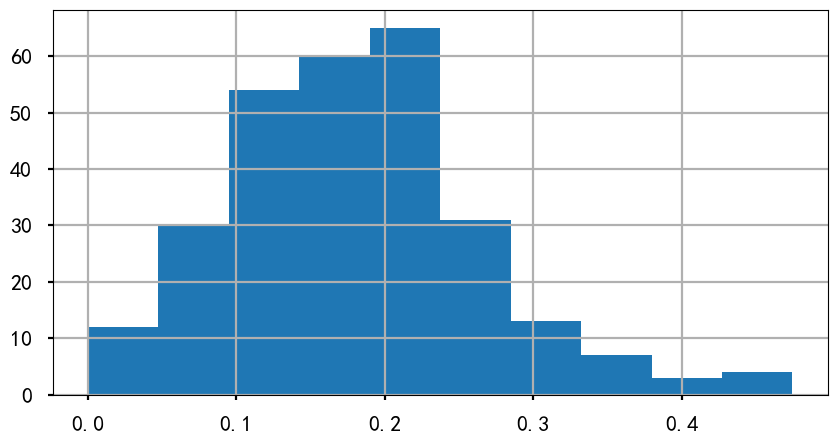

In [44]:
hsl['hsl'].hist(figsize=(10, 5))

<Axes: xlabel='end_record_time'>

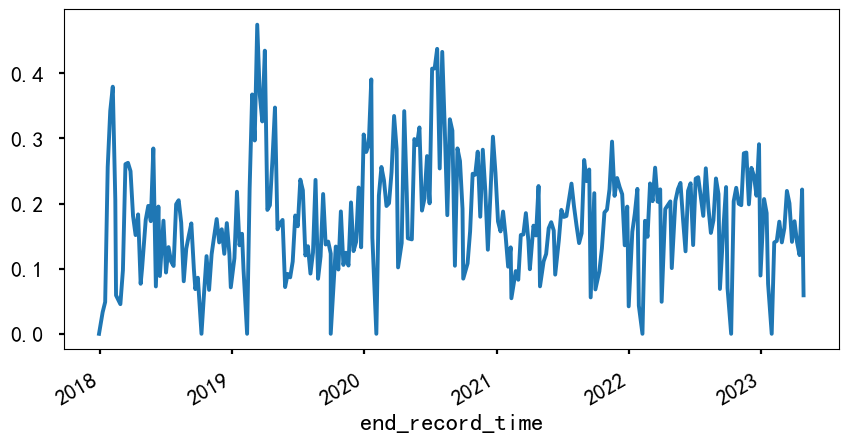

In [45]:
hsl.set_index('end_record_time')['hsl'].plot(figsize=(10, 5))

## 定期选股回测+自下而上的仓位管理

【按fct中的因子值<=0得到W2的转债持仓list(等权持有)，每期最多选30只，默认满仓，若满足条件的个券数量<30，则空出（1-N/30）的仓位】

In [46]:
class PMSimple2(PMSimple):
    def after_week_end(self):
         # 打印日志
        self.week_count += 1
        if self.week_count % 20 == 0:
            print(self.observer.time, self.balance['netAsset'])
            
        # 每周末， 取消所有的活跃订单(0号和1号订单代表不会被取消的订单)
        self.cancel_orders(self.active_orders)
        
        # 选择要持仓的股票
        mkt = self.get_mkt_obj()
        fct_temp = self.get_last_fct()
        l_positive = fct_temp['value'] < 0  # 小于0
        l_valide = fct_temp['code'].isin(
            mkt.current_frame.index)  # 有些股票有因子值但是没有行情信息
        data = fct_temp.loc[l_positive & l_valide].copy()

        # 计算标的之间的相对持仓比例， 如果是等权持仓随便传入一个正数即可
        data['ratio_relative'] = 7.5
        
        self.send_record = pd.concat((self.send_record, data))

      
        # 发送订单, 最多选30只
        if data.shape[0] > 30:
            data.sort_values('value', inplace=True, ascending=True)
            self.send_orders(
                data.head(30).copy(),  # 订单的信息， 需要的字段由 order_type决定， 大部分情况下包含 code，ratio_relative两列 或 code， targetVol两列组合
                order_type='target_ratio_vwap',  # 订单算法详见 cb_daily.CBTargetRatioVWAP
                ratio_to_netasset=1,  # 买入的金额占组合净资产的比例， 如果是1则表示满仓买入
                order_seq_short=5,  # 卖单的交易顺序
                order_seq_long=10)  # 买单的交易顺序
        else:
            self.send_orders(
                data,  # 订单的信息， 需要的字段由 order_type决定， 大部分情况下包含 code，ratio_relative两列 或 code， targetVol两列组合
                order_type='target_ratio_vwap',  # 订单算法详见 cb_daily.CBTargetRatioVWAP
                ratio_to_netasset=data.shape[0] / 30,  # 买入的金额占组合净资产的比例， 如果是1则表示满仓买入
                order_seq_short=5,  # 卖单的交易顺序
                order_seq_long=10)  # 买单的交易顺序

In [47]:
# 回测，加载策略，运行回测
ts.PortfolioManager = PMSimple2
obs = ts.run()

2018-05-13 00:00:00 104796028.93865944
2018-09-30 00:00:00 98505527.24935532
2019-02-17 00:00:00 107004832.37980339
2019-07-07 00:00:00 121557160.70701176
2019-11-24 00:00:00 127195533.17834757
2020-04-12 00:00:00 154441853.06769657
2020-08-30 00:00:00 182518280.0375892
2021-01-17 00:00:00 173302979.9850134
2021-06-06 00:00:00 206894104.98676896
2021-10-24 00:00:00 237072372.80127978
2022-03-13 00:00:00 257972003.15879387
2022-07-31 00:00:00 274388411.8652854
2022-12-18 00:00:00 261052968.23582822


### 结果

#### 组合现状

In [48]:
obs.position

,orderID,tradeID,secuType,code,transTime,transPrice,settlePrice,volume,frozenVol
0,22203,32405,cb_daily,128100.SZ,2021-08-23 15:00:00,101.251509,70.2027,36843.133844,36843.133844
1,22203,32448,cb_daily,128100.SZ,2021-08-24 15:00:00,101.132697,70.2027,11141.861750,11141.861750
2,22203,32484,cb_daily,128100.SZ,2021-08-25 15:00:00,100.546513,70.2027,11374.828948,11374.828948
3,22203,32512,cb_daily,128100.SZ,2021-08-26 15:00:00,100.878142,70.2027,6169.232443,6169.232443
4,22203,32537,cb_daily,128100.SZ,2021-08-27 15:00:00,101.642276,70.2027,4616.019777,4616.019777
...,...,...,...,...,...,...,...,...,...
264,30470,44169,cb_daily,123104.SZ,2023-04-27 15:00:00,120.830549,121.2795,21711.150000,21711.150000
265,30466,44171,cb_daily,110064.SH,2023-04-28 15:00:00,116.055613,116.4087,9872.500000,9872.500000
266,30469,44172,cb_daily,113033.SH,2023-04-28 15:00:00,106.098026,106.0539,15006.000000,15006.000000
267,30477,44173,cb_daily,123096.SZ,2023-04-28 15:00:00,107.806641,108.4462,6315.500000,6315.500000


In [49]:
obs.position['code'].nunique()

30

In [50]:
obs.balance

{'netAsset': 259147020.2872231, 'cash': 12260427.274282645, 'frozenCash': 0}

In [51]:
obs.active_orders

,orderID,secuType,code,orderTime,orderType,direction,targetPrice,targetVol,filledVol,offsetID,status,orderSeq
0,30529,cb_daily,128129.SZ,2023-04-30,vwap,net,101.0576,-2178.580189,0.0,42152,unsubmit,5
1,30530,cb_daily,128129.SZ,2023-04-30,vwap,net,101.0576,-3969.550553,0.0,42119,unsubmit,5
2,30531,cb_daily,128129.SZ,2023-04-30,vwap,net,101.0576,-2828.102471,0.0,42087,unsubmit,5
3,30532,cb_daily,128129.SZ,2023-04-30,vwap,net,101.0576,-9744.323203,0.0,42052,unsubmit,5
4,30533,cb_daily,128129.SZ,2023-04-30,vwap,net,101.0576,-7680.601280,0.0,41969,unsubmit,5
...,...,...,...,...,...,...,...,...,...,...,...,...
264,30793,cb_daily,110059.SH,2023-04-30,vwap,net,106.2471,-38345.529267,0.0,42724,unsubmit,5
265,30794,cb_daily,110057.SH,2023-04-30,vwap,net,140.5529,-62006.877815,0.0,44059,unsubmit,5
266,30795,cb_daily,110053.SH,2023-04-30,vwap,net,127.9809,-506.469279,0.0,43154,unsubmit,5
267,30796,cb_daily,110053.SH,2023-04-30,vwap,net,127.9809,-11782.765130,0.0,38928,unsubmit,5


In [52]:
obs.active_order_params

{}

#### 交易记录

In [53]:
obs.trade_records.tail()

,tradeID,orderID,secuType,code,transTime,direction,transPrice,transVol,offsetID,transCost
44170,44170,30488,cb_daily,128127.SZ,2023-04-28 15:00:00,net,108.601986,-13761.500000,36540,2989.052450
44171,44171,30466,cb_daily,110064.SH,2023-04-28 15:00:00,long,116.055613,9872.500000,-1,1145.759035
44172,44172,30469,cb_daily,113033.SH,2023-04-28 15:00:00,long,106.098026,15006.000000,-1,1592.106980
44173,44173,30477,cb_daily,123096.SZ,2023-04-28 15:00:00,long,107.806641,6315.500000,-1,680.852840
44174,44174,30470,cb_daily,123104.SZ,2023-04-28 15:00:00,long,121.716148,6772.260923,-1,824.293510


#### balance记录

In [54]:
obs.balance_records.tail()

,recordTime,netAsset,cash,frozenCash,date
1290,2023-04-24 20:00:00,2.571826e+08,2.781486e+07,3.036469e+07,2023-04-24
1291,2023-04-25 20:00:00,2.570633e+08,2.402190e+07,2.209580e+07,2023-04-25
1292,2023-04-26 20:00:00,2.570369e+08,1.864076e+07,1.589881e+07,2023-04-26
1293,2023-04-27 20:00:00,2.579916e+08,1.501615e+07,1.130344e+07,2023-04-27
1294,2023-04-28 20:00:00,2.591470e+08,1.226043e+07,7.137201e+06,2023-04-28


<Axes: xlabel='recordTime'>

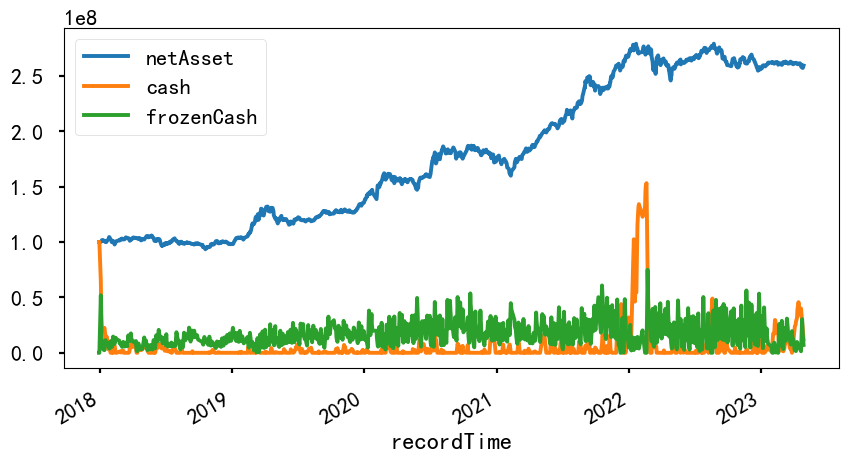

In [55]:
obs.balance_records.set_index('recordTime').plot(figsize=(10,5))

#### 持仓记录

In [56]:
obs.position_records

,recordTime,orderID,tradeID,secuType,code,transTime,transPrice,settlePrice,volume,frozenVol,date,mktv
0,2018-01-02 20:00:00,0,0,cb_daily,110032.SH,2018-01-02 15:00:00,126.488348,126.1414,27471.467074,-0.0,2018-01-02,3.465289e+06
1,2018-01-02 20:00:00,1,1,cb_daily,110033.SH,2018-01-02 15:00:00,116.973679,117.5827,9614.500000,-0.0,2018-01-02,1.130499e+06
2,2018-01-02 20:00:00,2,2,cb_daily,110034.SH,2018-01-02 15:00:00,109.211542,110.0532,10069.500000,-0.0,2018-01-02,1.108181e+06
3,2018-01-02 20:00:00,3,3,cb_daily,110038.SH,2018-01-02 15:00:00,107.198561,107.5221,3669.000000,-0.0,2018-01-02,3.944986e+05
4,2018-01-02 20:00:00,4,4,cb_daily,110039.SH,2018-01-02 15:00:00,106.939570,107.1314,9204.000000,-0.0,2018-01-02,9.860374e+05
...,...,...,...,...,...,...,...,...,...,...,...,...
469798,2023-04-28 20:00:00,30470,44169,cb_daily,123104.SZ,2023-04-27 15:00:00,120.830549,121.2795,21711.150000,-0.0,2023-04-28,2.633117e+06
469799,2023-04-28 20:00:00,30466,44171,cb_daily,110064.SH,2023-04-28 15:00:00,116.055613,116.4087,9872.500000,-0.0,2023-04-28,1.149245e+06
469800,2023-04-28 20:00:00,30469,44172,cb_daily,113033.SH,2023-04-28 15:00:00,106.098026,106.0539,15006.000000,-0.0,2023-04-28,1.591445e+06
469801,2023-04-28 20:00:00,30477,44173,cb_daily,123096.SZ,2023-04-28 15:00:00,107.806641,108.4462,6315.500000,-0.0,2023-04-28,6.848920e+05


### 检查

#### 持仓资产+现金等于基金净值

In [57]:
obs.check_position_net()

,netAsset,cash,position_asset,netAsset_cal
recordTime,,,,
2017-12-28 20:00:00,1.000000e+08,1.000000e+08,NaN,1.000000e+08
2017-12-29 20:00:00,1.000000e+08,1.000000e+08,NaN,1.000000e+08
2018-01-02 20:00:00,1.000429e+08,6.456189e+07,3.548097e+07,1.000429e+08
2018-01-03 20:00:00,1.005748e+08,4.108327e+07,5.949157e+07,1.005748e+08
2018-01-04 20:00:00,1.008997e+08,2.783183e+07,7.306790e+07,1.008997e+08
...,...,...,...,...
2023-04-24 20:00:00,2.571826e+08,2.781486e+07,2.293678e+08,2.571826e+08
2023-04-25 20:00:00,2.570633e+08,2.402190e+07,2.330414e+08,2.570633e+08
2023-04-26 20:00:00,2.570369e+08,1.864076e+07,2.383961e+08,2.570369e+08


#### 期初期末持仓价值变动+期间的交易的费用=期初期末净资产的变动

In [58]:
obs.check_trade_net()

{'nav_end': 259147020.2872231,
 'nav_start': 100042859.66130833,
 'trade_amount': 25896318.428195875,
 'trade_cost': 26405140.091660853,
 'pv_end': 246886593.0129417,
 'pv_start': 35480973.86716966,
 'nav_end_cal': 259147020.28722364}

In [59]:
res = obs.check_trade_net()
print('手续费：', -1*res['trade_cost'] / 1e8)

手续费： -0.26405140091660856


In [60]:
print('交易贡献：', (res['pv_end'] - res['pv_start'] - res['trade_amount'])/ 1e8)

交易贡献： 1.8550930071757619


#### 期末持仓等于期初持仓+期间的交易

In [61]:
obs.check_trade_position(start_datetime='2018-01-01', end_datetime='2019-01-01')

volume_start  volume_trade    volume_end    volume_net
secuType code                                                             
cb_daily 110032.SH  27471.467074 -2.747147e+04           NaN  0.000000e+00
         110033.SH   9614.500000 -9.614500e+03           NaN  0.000000e+00
         110034.SH  10069.500000 -1.006950e+04           NaN  0.000000e+00
         110038.SH   3669.000000 -3.669000e+03           NaN  3.637979e-12
         110039.SH   9204.000000 -9.204000e+03           NaN  7.275958e-12
...                          ...           ...           ...           ...
         128044.SZ           NaN  1.364242e-12           NaN  1.364242e-12
         128046.SZ           NaN  1.818989e-12           NaN  1.818989e-12
         128047.SZ           NaN  1.319210e+04  13192.101397  0.000000e+00
         128048.SZ           NaN  3.262364e+04  32623.644230  0.000000e+00
         128049.SZ           NaN  1.435331e+04  14353.311761  0.000000e+00

[92 rows x 4 columns]

### 分析

#### 基金指标

In [62]:
obs.pnl_analyse(freq='day', benchmark=index,  chicol=True)

,总收益率,年化收益率,年化风险,最大回撤,夏普比率,信息比率
netAsset,1.579916,0.195841,0.132968,0.145101,1.472838,1.179808
benchmark,0.807694,0.118206,0.126991,0.157759,0.930818,NaN


#### 净值

In [63]:
obs.get_pnl_net(benchmark=index, freq='day')

,netAsset,benchmark
2017-12-28,1.000000e+08,1.180143
2017-12-29,1.000000e+08,1.186481
2018-01-02,1.000429e+08,1.196686
2018-01-03,1.005748e+08,1.210064
2018-01-04,1.008997e+08,1.215429
...,...,...
2023-04-21,2.584034e+08,2.133467
2023-04-24,2.571826e+08,2.117063
2023-04-25,2.570633e+08,2.105373
2023-04-26,2.570369e+08,2.124780


#### 净值图

##### 2022年后因子值大于0的比例很高， 详见信号处理因子值部分

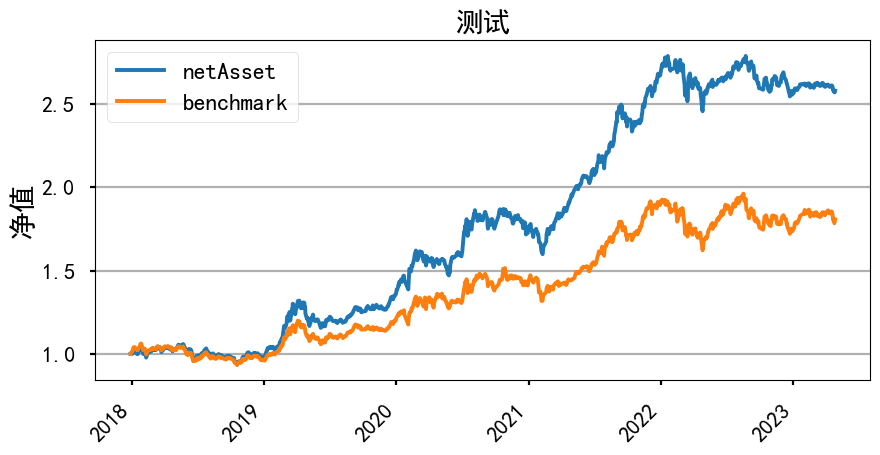

In [64]:
obs.pnl_plot(title='测试',benchmark=index, freq='day')

#### 换手率

In [65]:
obs.cal_hsl()

{'start_record_time': Timestamp('2017-12-28 20:00:00'),
 'end_record_time': Timestamp('2023-04-28 20:00:00'),
 'nav_end': 259147020.2872231,
 'nav_start': 100000000.0,
 'trade_amount': 17647461545.410957,
 'trade_cost': 26440542.803155225,
 'hsl': 49.21077188411487}

In [66]:
obs.cal_hsl_batch(t_start, t_end).tail()

,start_record_time,end_record_time,nav_end,nav_start,trade_amount,trade_cost,hsl
274,2023-03-27 20:00:00,2023-04-03 20:00:00,2.614200e+08,2.618127e+08,5.965220e+07,99934.161454,0.114198
275,2023-04-03 20:00:00,2023-04-10 20:00:00,2.607780e+08,2.614200e+08,6.906935e+07,109107.002527,0.132476
276,2023-04-10 20:00:00,2023-04-17 20:00:00,2.611776e+08,2.607780e+08,8.253436e+07,125224.810208,0.158365
277,2023-04-17 20:00:00,2023-04-24 20:00:00,2.571826e+08,2.611776e+08,7.773754e+07,113355.440182,0.150187
278,2023-04-24 20:00:00,2023-04-28 20:00:00,2.591470e+08,2.571826e+08,3.111320e+07,38912.037150,0.060334


## 定期选股回测+止盈止损事件

1. 【按fct中的因子值排名后20%得到W2的转债持仓list(等权持有)】
2. 【若持仓期间W1-W2任意一个交易日，个券累计涨幅超过10%，则于次日起清仓，未成交的买单取消】；
3. 【若持仓期间W1-W2任意一个交易日，个券累计跌幅超过5%，则于次日起清仓，未成交的买单取消】；

In [67]:
class PMSimple3(PMSimple):
    def after_close(self):
        # 取消买入量不足的订单
        super().after_close()
        # 如果成交量小于1手则取消订单

        if hasattr(self, 'is_weekend'):
            # 计算需要平仓的标的集合
            mkt = self.get_mkt_obj()
            if self.is_weekend:
                self.buy_price = mkt.current_frame['vwapAdj']
                self.is_weekend = False
            pnl = mkt.current_frame['closeAdj'] / self.buy_price - 1
            set_stop = set(pnl.index[(pnl > 0.1) | (pnl < -0.05)])

            # 取消相关活跃订单
            active_orders = self.active_orders
            l_stop = active_orders['code'].isin(set_stop)
            l_buy = active_orders['targetVol'] > active_orders['filledVol']
            self.cancel_orders(active_orders.loc[l_stop & l_buy])

            # 卖出相关的持仓
            position = self.position
            l_stop = position['code'].isin(set_stop)
            data = self.reverse_position(position.loc[l_stop].copy())
            self.send_orders(data, order_type='vwap', order_seq=5)

    def after_week_end(self):
        self.is_weekend = True
        super().after_week_end()

In [68]:
# 回测，加载策略，运行回测
ts.PortfolioManager = PMSimple3
obs = ts.run()

2018-05-13 00:00:00 108502853.51230459
2018-09-30 00:00:00 101343349.75939207
2019-02-17 00:00:00 111131698.15039183
2019-07-07 00:00:00 132670168.06767857
2019-11-24 00:00:00 138849087.3207914
2020-04-12 00:00:00 164235176.6076804
2020-08-30 00:00:00 189908260.01326528
2021-01-17 00:00:00 177953909.38826707
2021-06-06 00:00:00 207331984.64869732
2021-10-24 00:00:00 229137196.46040532
2022-03-13 00:00:00 249113445.33353087
2022-07-31 00:00:00 263017986.8925983
2022-12-18 00:00:00 252169144.2021244


### 分析

#### 基金指标

In [69]:
obs.pnl_analyse(freq='day', benchmark=index,  chicol=True)

,总收益率,年化收益率,年化风险,最大回撤,夏普比率,信息比率
netAsset,1.589589,0.196686,0.128710,0.144678,1.528136,1.184467
benchmark,0.807694,0.118206,0.126991,0.157759,0.930818,NaN


#### 净值

In [70]:
obs.get_pnl_net(benchmark=index, freq='day')

,netAsset,benchmark
2017-12-28,1.000000e+08,1.180143
2017-12-29,1.000000e+08,1.186481
2018-01-02,1.000008e+08,1.196686
2018-01-03,1.000072e+08,1.210064
2018-01-04,1.000622e+08,1.215429
...,...,...
2023-04-21,2.575314e+08,2.133467
2023-04-24,2.568402e+08,2.117063
2023-04-25,2.565973e+08,2.105373
2023-04-26,2.574436e+08,2.124780


#### 净值图

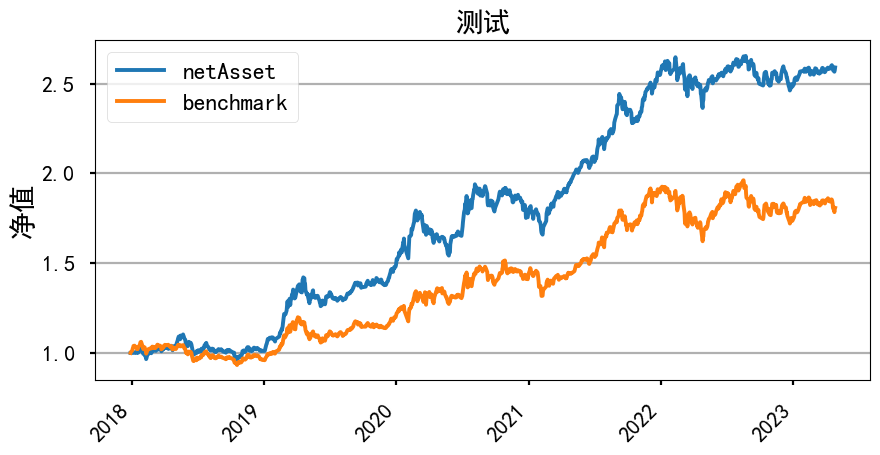

In [71]:
obs.pnl_plot(title='测试',benchmark=index, freq='day')

#### 换手率

In [72]:
obs.cal_hsl()

{'start_record_time': Timestamp('2017-12-28 20:00:00'),
 'end_record_time': Timestamp('2023-04-28 20:00:00'),
 'nav_end': 259957618.478978,
 'nav_start': 100000000.0,
 'trade_amount': 22549862502.341854,
 'trade_cost': 33796674.72023059,
 'hsl': 62.7397727334975}

In [73]:
obs.cal_hsl_batch(t_start, t_end).tail()

,start_record_time,end_record_time,nav_end,nav_start,trade_amount,trade_cost,hsl
274,2023-03-27 20:00:00,2023-04-03 20:00:00,2.580569e+08,2.577710e+08,8.866589e+07,133065.362642,0.172148
275,2023-04-03 20:00:00,2023-04-10 20:00:00,2.583913e+08,2.580569e+08,7.248188e+07,113352.462059,0.140566
276,2023-04-10 20:00:00,2023-04-17 20:00:00,2.600442e+08,2.583913e+08,7.079794e+07,101674.782134,0.136757
277,2023-04-17 20:00:00,2023-04-24 20:00:00,2.568402e+08,2.600442e+08,1.287495e+08,194925.142233,0.249465
278,2023-04-24 20:00:00,2023-04-28 20:00:00,2.599576e+08,2.568402e+08,3.879639e+07,61504.497884,0.075190


## 定期选股回测+自下而上的仓位管理+根据因子调入调出事件

1. 【按fct中的因子值排名后20%得到W2的转债持仓list(等权持有)】
2. W1-W2之间的每个交易日，观察因子排名，若当日有N只持仓个券的排名跌出了20%（不满足入选list的条件），则于次日卖出该N只个券（取消未成交的买单单），卖出个券所腾出的仓位，由当日排名最靠前（fct因子值最低）且不在list中的N只个券填充

In [74]:
class PMSimple4(PMSimple):
    def after_close(self):
        # 先根据not_include以及买入金额小于15万的条件取消订单，卖出持仓
        super().after_close()

        # 动态调参
        if hasattr(self, 'set_buylist'):
            # 计算当前符合条件的股票
            self.select_secu_tobuy()
            self.set_buylist_now = set(self.order_data['code'])

            # 取消不在当前列表的买单
            active_orders = self.active_orders
            l_buy = active_orders['targetVol'] > active_orders['filledVol']
            l_tocancel = ~active_orders['code'].isin(self.set_buylist_now)
            self.cancel_orders(active_orders.loc[l_buy & l_tocancel])

            # 卖出不在当前列表的持仓
            l_to_net = ~self.position['code'].isin(self.set_buylist_now)
            data = self.reverse_position(self.position.loc[l_to_net].copy())
            self.send_orders(data, order_type='vwap', order_seq=5)

            # 买入新进的股票
            if len(self.set_buylist_now) > 0:
                set_tobuy = self.set_buylist_now - self.set_buylist
                data = pd.DataFrame(set_tobuy, columns=['code'])
                data['ratio_relative'] = 7.5
                self.send_orders(
                    data,  # 订单的信息， 需要的字段由 order_type决定， 大部分情况下包含 code，ratio_relative两列 或 code， targetVol两列组合
                    order_type='ratio_vwap',  # 订单算法详见 cb_daily.CBRatioVWAP
                    ratio_to_netasset=len(set_tobuy) / len(self.set_buylist_now),  # 买入的金额占组合净资产的比例， 如果是1则表示满仓买入
                    order_seq=10)

            # 更新股票列表
            self.set_buylist = self.set_buylist_now

    def after_week_end(self):
        super().after_week_end()
        self.set_buylist = set(self.order_data['code'])


class PMSimple5(PMSimple):
    "另一种实现，每次收盘后都进行再平衡"

    def after_close(self):
        self.cancel_orders(self.active_orders)

        self.select_secu_tobuy()
        # 计算标的之间的相对持仓比例， 如果是等权持仓随便传入一个正数即可
        self.order_data['ratio_relative'] = 7.5

        self.send_orders(
            self.
            order_data,  # 订单的信息， 需要的字段由 order_type决定， 大部分情况下包含 code，ratio_relative两列 或 code， targetVol两列组合
            order_type='target_ratio_vwap',  # 订单算法详见 cb_daily.CBTargetRatioVWAP
            ratio_to_netasset=1,  # 买入的金额占组合净资产的比例， 如果是1则表示满仓买入
            order_seq_short=5,  # 卖单的交易顺序
            order_seq_long=10)  # 买单的交易顺序

    def after_week_end(self):
        self.week_count += 1
        if self.week_count % 20 == 0:
            print(self.observer.time, self.balance['netAsset'])
        # 每周末， 取消所有的活跃订单(0号和1号订单代表不会被取消的订单)

In [75]:
# 回测，加载策略，运行回测
ts.PortfolioManager = PMSimple4
obs = ts.run()

2018-05-13 00:00:00 110844374.11333667
2018-09-30 00:00:00 106640232.33905737
2019-02-17 00:00:00 118328937.09053232
2019-07-07 00:00:00 144124553.04420304
2019-11-24 00:00:00 153617755.09390545
2020-04-12 00:00:00 181810764.65104583
2020-08-30 00:00:00 207860617.4287039
2021-01-17 00:00:00 200966962.50883144
2021-06-06 00:00:00 233010809.54756868
2021-10-24 00:00:00 272628608.7654984
2022-03-13 00:00:00 297885450.56131166
2022-07-31 00:00:00 317004533.2955001
2022-12-18 00:00:00 300391339.8145488


In [76]:
# 回测，加载策略，运行回测
ts.PortfolioManager = PMSimple5
obs_5 = ts.run()

2018-05-13 00:00:00 111679631.61625074
2018-09-30 00:00:00 107212286.63051142
2019-02-17 00:00:00 119460199.51587948
2019-07-07 00:00:00 147534310.43065146
2019-11-24 00:00:00 157115186.45140067
2020-04-12 00:00:00 188788138.2920724
2020-08-30 00:00:00 218068772.90601113
2021-01-17 00:00:00 210162277.09164262
2021-06-06 00:00:00 243019313.54493955
2021-10-24 00:00:00 284005161.74990606
2022-03-13 00:00:00 309250852.15216994
2022-07-31 00:00:00 330042617.1640844
2022-12-18 00:00:00 313454004.54014665


### 检查

#### 持仓资产+现金等于基金净值

In [77]:
obs.check_position_net()

,netAsset,cash,position_asset,netAsset_cal
recordTime,,,,
2017-12-28 20:00:00,1.000000e+08,1.000000e+08,NaN,1.000000e+08
2017-12-29 20:00:00,1.000000e+08,1.000000e+08,NaN,1.000000e+08
2018-01-02 20:00:00,1.000008e+08,9.901474e+07,9.860374e+05,1.000008e+08
2018-01-03 20:00:00,1.000072e+08,9.779027e+07,2.216969e+06,1.000072e+08
2018-01-04 20:00:00,1.000622e+08,9.612653e+07,3.935685e+06,1.000622e+08
...,...,...,...,...
2023-04-24 20:00:00,2.998593e+08,6.121561e+06,2.937377e+08,2.998593e+08
2023-04-25 20:00:00,2.995835e+08,0.000000e+00,2.995835e+08,2.995835e+08
2023-04-26 20:00:00,3.009378e+08,0.000000e+00,3.009378e+08,3.009378e+08


#### 期初期末持仓价值变动+期间的交易的费用=期初期末净资产的变动

In [78]:
obs.check_trade_net()

{'nav_end': 303839851.58903044,
 'nav_start': 100000781.3338,
 'trade_amount': 38096000.6840008,
 'trade_cost': 59530502.94203432,
 'pv_end': 302451611.28686553,
 'pv_start': 986037.4055999999,
 'nav_end_cal': 303839851.5890304}

In [79]:
res = obs.check_trade_net()
print('手续费：', -1*res['trade_cost'] / 1e8)

手续费： -0.5953050294203432


In [80]:
print('交易贡献：', (res['pv_end'] - res['pv_start'] - res['trade_amount'])/ 1e8)

交易贡献： 2.6336957319726473


#### 期末持仓等于期初持仓+期间的交易

In [81]:
obs.check_trade_position(start_datetime='2018-01-01', end_datetime='2019-01-01')

volume_start  volume_trade    volume_end    volume_net
secuType code                                                             
cb_daily 110039.SH        9204.0 -9.204000e+03           NaN  0.000000e+00
         110041.SH           NaN  0.000000e+00           NaN  0.000000e+00
         110042.SH           NaN  0.000000e+00           NaN  0.000000e+00
         110043.SH           NaN  3.637979e-12           NaN  3.637979e-12
         110044.SH           NaN  7.210506e+04  72105.063369  0.000000e+00
...                          ...           ...           ...           ...
         128044.SZ           NaN -2.273737e-13           NaN -2.273737e-13
         128046.SZ           NaN  1.818989e-12           NaN  1.818989e-12
         128048.SZ           NaN  0.000000e+00           NaN  0.000000e+00
         128049.SZ           NaN  4.593777e+04  45937.771563  0.000000e+00
         128050.SZ           NaN  3.704060e+03   3704.060446  0.000000e+00

[64 rows x 4 columns]

### 分析

#### 基金指标

In [82]:
obs.pnl_analyse(freq='day', benchmark=index,  chicol=True)

,总收益率,年化收益率,年化风险,最大回撤,夏普比率,信息比率
netAsset,2.021623,0.232042,0.133479,0.140130,1.738411,1.643414
benchmark,0.807694,0.118206,0.126991,0.157759,0.930818,NaN


#### 净值

In [83]:
obs.get_pnl_net(benchmark=index, freq='day')

,netAsset,benchmark
2017-12-28,1.000000e+08,1.180143
2017-12-29,1.000000e+08,1.186481
2018-01-02,1.000008e+08,1.196686
2018-01-03,1.000072e+08,1.210064
2018-01-04,1.000622e+08,1.215429
...,...,...
2023-04-21,3.015802e+08,2.133467
2023-04-24,2.998593e+08,2.117063
2023-04-25,2.995835e+08,2.105373
2023-04-26,3.009378e+08,2.124780


#### 净值图

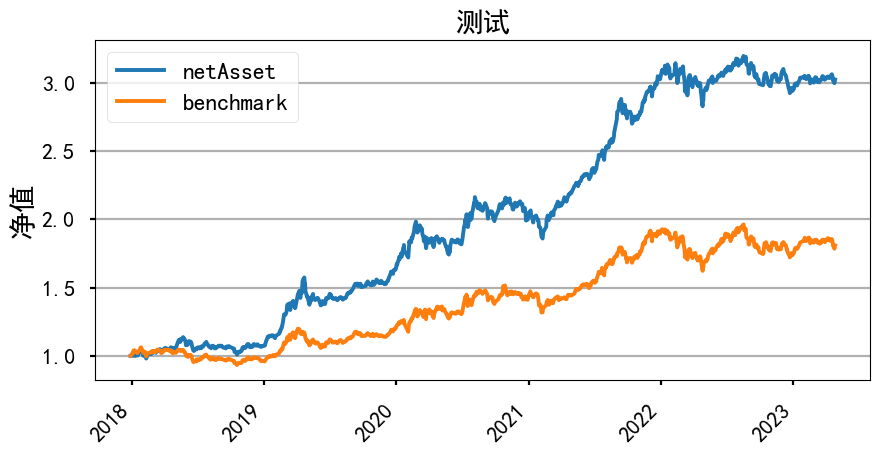

In [84]:
obs.pnl_plot(title='测试',benchmark=index, freq='day')

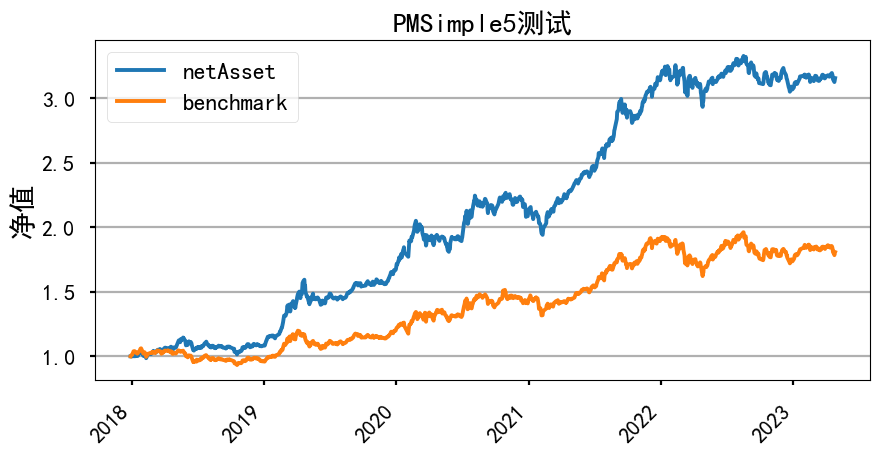

In [85]:
obs_5.pnl_plot(title='PMSimple5测试',benchmark=index, freq='day')

#### 换手率

In [86]:
t_start = date_weekend
t_end = date_weekend + pd.offsets.Day(7+2)
[*zip(t_start, t_end)][:5]

[(Timestamp('2017-01-01 00:00:00', freq='W-SUN'),
  Timestamp('2017-01-10 00:00:00')),
 (Timestamp('2017-01-08 00:00:00', freq='W-SUN'),
  Timestamp('2017-01-17 00:00:00')),
 (Timestamp('2017-01-15 00:00:00', freq='W-SUN'),
  Timestamp('2017-01-24 00:00:00')),
 (Timestamp('2017-01-22 00:00:00', freq='W-SUN'),
  Timestamp('2017-01-31 00:00:00')),
 (Timestamp('2017-01-29 00:00:00', freq='W-SUN'),
  Timestamp('2017-02-07 00:00:00'))]

In [87]:
hsl = []
for t_s, t_e in zip(t_start, t_end):
    res = obs.cal_hsl(t_s, t_e)
    if res is not None:
        res['date'] = t_e
        hsl += [res]
hsl = pd.DataFrame(hsl).set_index('date')
hsl.tail()

,start_record_time,end_record_time,nav_end,nav_start,trade_amount,trade_cost,hsl
date,,,,,,,
2023-04-04,2023-03-27 20:00:00,2023-04-03 20:00:00,3.037750e+08,3.038797e+08,1.735356e+08,260200.645508,0.286011
2023-04-11,2023-04-03 20:00:00,2023-04-10 20:00:00,3.037132e+08,3.037750e+08,1.411839e+08,217321.933550,0.232764
2023-04-18,2023-04-10 20:00:00,2023-04-17 20:00:00,3.058941e+08,3.037132e+08,2.132135e+08,315595.000613,0.350273
2023-04-25,2023-04-17 20:00:00,2023-04-24 20:00:00,2.998593e+08,3.058941e+08,2.014396e+08,303016.978408,0.333044
2023-05-02,2023-04-24 20:00:00,2023-04-28 20:00:00,3.038399e+08,2.998593e+08,2.365755e+08,352672.872007,0.392461


<Axes: >

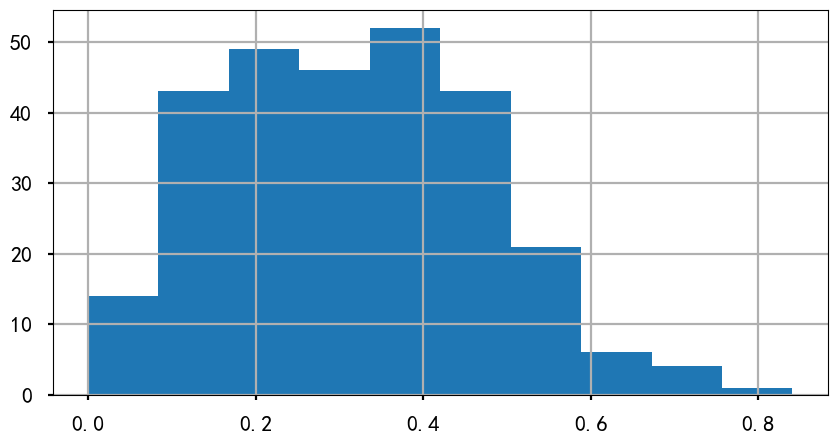

In [88]:
hsl['hsl'].hist(figsize=(10, 5))

<Axes: xlabel='date'>

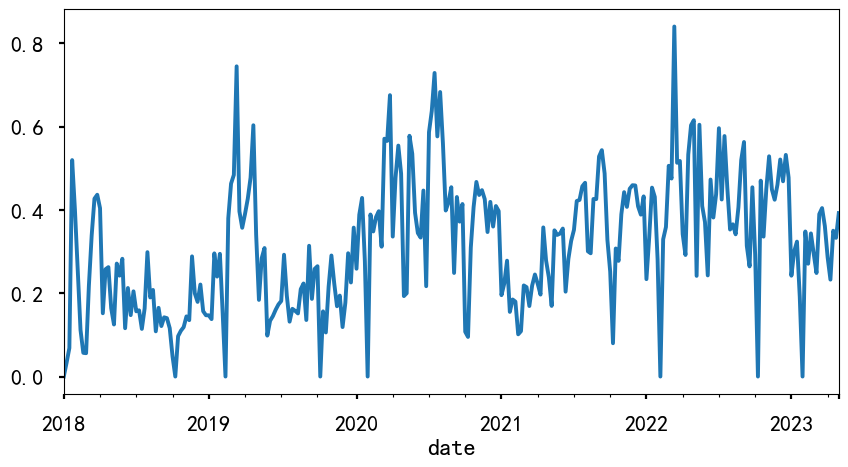

In [89]:
hsl['hsl'].plot(figsize=(10, 5))

In [93]:
ts.pm.get_mkt_data().tail(50).to_excel("数据样例.xlsx")

In [94]:
fct.tail(50).to_excel("信号样例.xlsx")

In [95]:
index.to_excel("指数数据.xlsx")